In [100]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

In [101]:
df = pd.read_csv('../data/preprocessed/layer1/matches_stats_data_1.csv')
result_cols = ['result_A', 'result_D', 'result_H']

In [102]:
df = df[[col for col in df if col not in result_cols]+[col for col in result_cols if col in df]]
df['season'] = df['season'].apply(lambda x:  int(x[2:4]) - 19)
df['result_H'] = df['result_H'].apply(lambda x: 1 if x else 0)
df['result_A'] = df['result_A'].apply(lambda x: 1 if x else 0)
df['result_D'] = df['result_D'].apply(lambda x: 1 if x else 0)
df = df.drop(columns='round')

In [103]:
home_columns = ['gf','ga', 
                'h_xg',
                'h_xga', 'h_standard sot', 'h_kp', 'h_xa', 'h_poss_x',
                'h_touches att pen', 'h_carries prgdist', 'h_progressive passing dist',
                'h_tackles tklw', 'h_challenges tkl%', 'h_saves',
                'h_strength_overall_home', 'h_overall_rating', 'h_attack_rating',
                'h_midfield_rating', 'h_defence_rating', 'h_avg_age','soh']
away_columns = ['ga','gf',
                'a_xg', 
                'a_xga','a_standard sot', 'a_kp', 'a_xa', 'a_poss_x', 
                'a_touches att pen','a_carries prgdist', 'a_progressive passing dist', 
                'a_tackles tklw','a_challenges tkl%', 'a_saves',
                'a_strength_overall_away', 'a_overall_rating', 'a_attack_rating',
                'a_midfield_rating', 'a_defence_rating', 'a_avg_age', 'soa']

bet_columns = ['b365h', 'b365d', 'b365a']

In [104]:
df[(df['hometeam']=='AVL') & (df['awayteam']=='ARS') & (df['season']==1)][result_cols].values

array([[0, 0, 1]])

In [105]:
Home_run = pd.read_csv('../data/preprocessed/layer2/fts_home_0.csv')
Home_run['season'] = Home_run['season'].apply(lambda x:  int(x[2:4]) - 19)
# Home_run = Home_run.rename(columns={'team':'hometeam'})
Home_run = Home_run.set_index(['team','opponent_team']).sort_index()


Away_run = pd.read_csv('../data/preprocessed/layer2/fts_away_0.csv')
Away_run['season'] = Away_run['season'].apply(lambda x:  int(x[2:4]) - 19)
# Away_run = Away_run.rename(columns={'team':'awayteam'})
Away_run = Away_run.set_index(['team','opponent_team']).sort_index()


Home_sub = pd.read_csv('../data/preprocessed/layer2/fts_home_1.csv')
Home_sub['season'] = Home_sub['season'].apply(lambda x:  int(x[2:4]) - 19)
Home_sub = Home_sub.set_index(['team','opponent_team']).sort_index()


Away_sub = pd.read_csv('../data/preprocessed/layer2/fts_away_1.csv')
Away_sub['season'] = Away_sub['season'].apply(lambda x:  int(x[2:4]) - 19)
Away_sub = Away_sub.set_index(['team','opponent_team']).sort_index()

In [106]:
ss20 = df[df['season']==1]
hr20 = Home_run[Home_run['season']==1].drop(columns='season')
hs20 = Home_sub[Home_sub['season']==1].drop(columns='season')
ar20 = Away_run[Away_run['season']==1].drop(columns='season')
as20 = Away_sub[Away_sub['season']==1].drop(columns='season')

In [107]:
def prepare_data(org_df: pd.DataFrame,hr:pd.DataFrame, ar:pd.DataFrame,
                hsub: pd.DataFrame, asub: pd.DataFrame, prematch: int =5):
    match_list = hr.index.drop_duplicates().values.tolist()
    h_team_data = {}
    a_team_data = {}
    final_dict = {}
    for team,_ in match_list:
        h_team_data[team]=[]
        a_team_data[team]=[]
        final_dict[team] = {'HOME':{}, 'AWAY':{}}
    for hometeam, awayteam in match_list:
        tmp_data = org_df[(org_df['hometeam']==hometeam) & (org_df['awayteam']==awayteam)]
        h_team_data[hometeam].append(np.hstack([hr.loc[hometeam, awayteam].iloc[:,1:-2].mean().values,
                                                hsub.loc[hometeam, awayteam].iloc[:,2:-2].mean().values,tmp_data[home_columns].values[0] ]))
        a_team_data[awayteam].append(np.hstack([ar.loc[awayteam, hometeam].iloc[:,1:-2].mean().values,
                                                asub.loc[awayteam, hometeam].iloc[:,2:-2].mean().values, tmp_data[away_columns].values[0]]))
    
    for team, matches in h_team_data.items():
        for idx in range(1,len(matches)):
            if idx < prematch-1:
                pre_match_data = matches[:idx+1]
            else:
                pre_match_data = matches[idx-prematch+1:idx+1]
            pre_match_data_key = hr[hr['round']==int(pre_match_data[-1][0])].loc[team].index.unique().values[0]
            pre_match_data = np.vstack(pre_match_data)
            final_dict[team]['HOME'][pre_match_data_key] = pre_match_data[:-1, 1:]
            
    for team, matches in a_team_data.items():
        for idx in range(1, len(matches)):
            if idx < prematch-1:
                pre_match_data = matches[:idx+1]
            else:
                pre_match_data = matches[idx-prematch+1:idx+1]
            pre_match_data_key = ar[ar['round']==int(pre_match_data[-1][0])].loc[team].index.unique().values[0]
            pre_match_data = np.vstack(pre_match_data)
            final_dict[team]['AWAY'][pre_match_data_key] = pre_match_data[:-1, 1:]
            
    return final_dict

In [108]:
tmp_dict = prepare_data(ss20, hr20, ar20, hs20, as20)

In [109]:
def create_X_y(final_dict: dict, org_data: pd.DataFrame):

    X =np.empty((0,77))
    y = []
    data_dict = {}
    for team_idx in final_dict.keys():
        for opponent, match_data in final_dict[team_idx]['HOME'].items():
            match_dict = {}
            team1_data = match_data
            try:
                team2_data = final_dict[opponent]['AWAY'][team_idx]
            except KeyError:
                continue
            away, _, home, h,d,a = org_data[(org_data['hometeam']==team_idx) & (org_data['awayteam']==opponent)][result_cols+bet_columns].values.tolist()[0]
            
            weights_1 = np.ones(team1_data.shape[0])/(team1_data.shape[0])
            weights_2 = np.ones(team2_data.shape[0])/(team2_data.shape[0])
            team1_prematch = np.dot(weights_1, team1_data).reshape(-1)
            team2_prematch = np.dot(weights_2, team2_data).reshape(-1)
            prematch = np.concatenate((team1_prematch, team2_prematch))
            prematch = np.concatenate((prematch, np.array([h,d,a])))
            
            this_match_res = 0 if home == 1 else 2 if away == 1 else 1
            X = np.vstack((X, prematch))
            y.append(this_match_res)
            
            match_dict['x'] = prematch
            match_dict['y'] = this_match_res
            data_dict[team_idx+opponent] = match_dict
    y = np.asarray(y)
    return data_dict, X, y

In [110]:
def handle_data(ss: int, prematch:int = 5, seq: bool = False):
    global df, Home_run, Home_sub, Away_run, Away_sub
    tmpss=ss-19
    sscheck = df[df['season']==tmpss]
    hrss = Home_run[Home_run['season']==tmpss].drop(columns='season')
    hsss = Home_sub[Home_sub['season']==tmpss].drop(columns='season')
    arss = Away_run[Away_run['season']==tmpss].drop(columns='season')
    asss = Away_sub[Away_sub['season']==tmpss].drop(columns='season')
    finalss = prepare_data(sscheck,hrss, arss,hsss, asss,prematch=prematch)
    _, X, y = create_X_y(finalss, sscheck)
    print(X.shape, y.shape)
    if seq:
        np.save(f'Both/Data/inputs{ss}_{ss+1}_seq.npy',X)
        np.save(f'Both/Data/outputs{ss}_{ss+1}_seq.npy',y)
    else:
        np.save(f'Both/Data/Playerinputs{ss}_{ss+1}.npy',X)
        np.save(f'Both/Data/Playeroutputs{ss}_{ss+1}.npy',y)

In [111]:
handle_data(21,4)
handle_data(22,4)
handle_data(23,4)
handle_data(20,4)

(318, 77) (318,)
(327, 77) (327,)
(333, 77) (333,)
(320, 77) (320,)


In [112]:
input_21 = np.load('Both/Data/Playerinputs21_22.npy', allow_pickle=True)
y_21 = np.load('Both/Data/Playeroutputs21_22.npy', allow_pickle=True)
input_22 = np.load('Both/Data/Playerinputs22_23.npy', allow_pickle=True)
y_22 = np.load('Both/Data/Playeroutputs22_23.npy', allow_pickle=True)
input_23 = np.load('Both/Data/Playerinputs23_24.npy', allow_pickle=True)
y_23 = np.load('Both/Data/Playeroutputs23_24.npy', allow_pickle=True)


INPUTS = np.vstack((input_21,input_22))
# INPUTS = np.vstack((INPUTS, input_22_1_1))
LABELS = np.concatenate((y_21,y_22))
# LABELS = np.concatenate((LABELS, y_22))

In [113]:
def cal_profit(y_predict):
    global input_23, y_23
    bet_rate = input_23[:,-3:]
    original = 2*(y_predict.shape[0])
    money = original
    for i in range(y_predict.shape[0]):
        if y_predict[i] == y_23[i]:
            money+= (bet_rate[i][y_predict[i]]-1)*2
        else:
            money-=2
    return money/original *100 - 100

0.6232558139534884


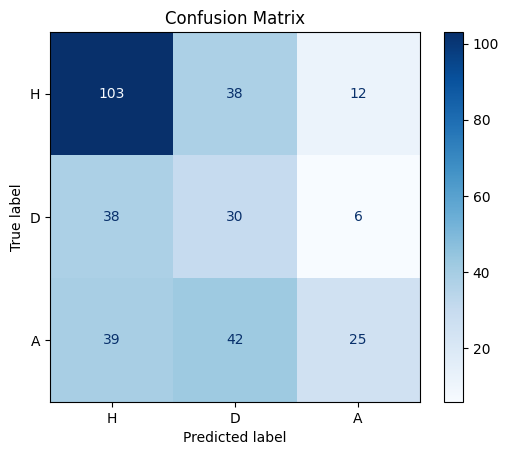

profit: 4.471 %


0.4744744744744745

In [114]:
svc_ovo = SVC(kernel='linear')
svc_ovo.fit(INPUTS, LABELS)
y_predict = svc_ovo.predict(input_23)
print(accuracy_score(LABELS, svc_ovo.predict(INPUTS)))
cm = confusion_matrix(y_23, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["H", "D", "A"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
print(f"profit: {cal_profit(y_predict):.3f} %")
accuracy_score(y_23, y_predict)

1.0


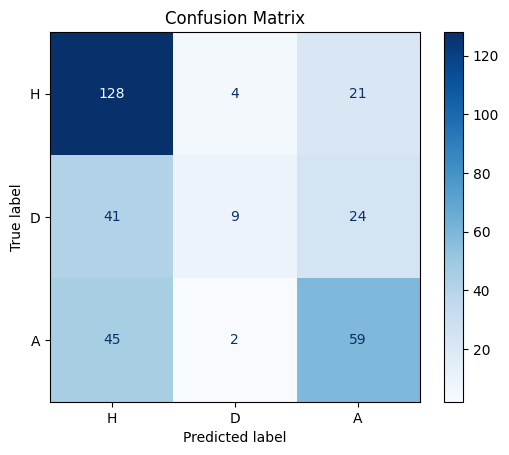

profit: 10.333 %


0.5885885885885885

In [115]:
rf_clf = RandomForestClassifier(criterion='entropy', random_state=42)
rf_clf.fit(INPUTS, LABELS)
y_predict = rf_clf.predict(input_23)
print(accuracy_score(LABELS, rf_clf.predict(INPUTS)))
cm = confusion_matrix(y_23, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["H", "D", "A"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
print(f"profit: {cal_profit(y_predict):.3f} %")
accuracy_score(y_23, y_predict)


0.9906976744186047


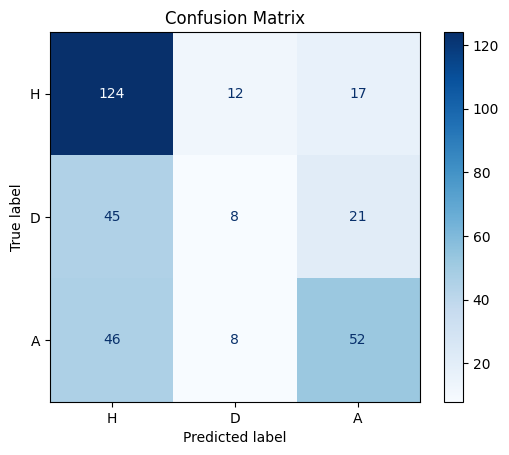

profit: 8.832 %


0.5525525525525525

In [116]:
xGboost_clf = GradientBoostingClassifier(random_state=42)
xGboost_clf.fit(INPUTS, LABELS)
y_predict = xGboost_clf.predict(input_23)
print(accuracy_score(LABELS, xGboost_clf.predict(INPUTS)))
cm = confusion_matrix(y_23, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["H", "D", "A"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
print(f"profit: {cal_profit(y_predict):.3f} %")
accuracy_score(y_23, y_predict)


In [117]:
import pickle

# Save the model
with open('Both/Model/H_D_A/SVM.pkl', 'wb') as f:
    pickle.dump(svc_ovo, f)

with open('Both/Model/H_D_A/RandomForest.pkl', 'wb') as f:
    pickle.dump(rf_clf, f)
    
with open('Both/Model/H_D_A/xGBoost.pkl', 'wb') as f:
    pickle.dump(xGboost_clf, f)


In [120]:
import numpy as np
from collections import Counter

# Check label distribution
label_counts = Counter(LABELS)
print(f"Label Distribution: {label_counts}")


from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
INPUTS_balanced, LABELS_balanced = smote.fit_resample(INPUTS, LABELS)

print(f"New Label Distribution: {Counter(LABELS_balanced)}")



Label Distribution: Counter({0: 285, 2: 200, 1: 160})
New Label Distribution: Counter({0: 285, 1: 285, 2: 285})


0.9875968992248062


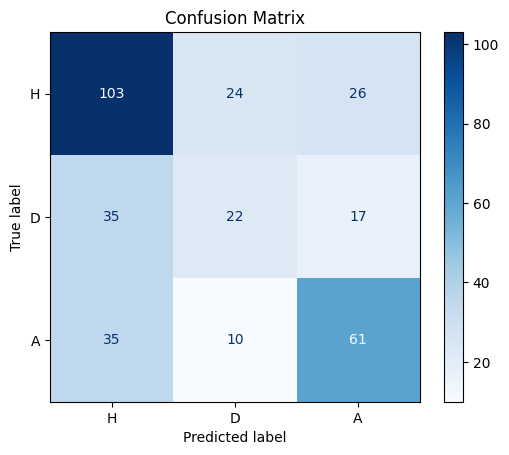

profit: 20.835 %


0.5585585585585585

In [123]:
xGboost_clf = GradientBoostingClassifier(random_state=42)
xGboost_clf.fit(INPUTS_balanced, LABELS_balanced)
y_predict = xGboost_clf.predict(input_23)
print(accuracy_score(LABELS, xGboost_clf.predict(INPUTS)))
cm = confusion_matrix(y_23, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["H", "D", "A"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
print(f"profit: {cal_profit(y_predict):.3f} %")
accuracy_score(y_23, y_predict)
